## Notebook is still under construction
### Dataset Link-
https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv("DailyDelhiClimateTrain.csv", index_col="date", parse_dates=True)
train.index.freq = 'D'

In [3]:
test = pd.read_csv("DailyDelhiClimateTest.csv", index_col="date", parse_dates=True)
test.index.freq = 'D'

In [4]:
train.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [5]:
train.dtypes

meantemp        float64
humidity        float64
wind_speed      float64
meanpressure    float64
dtype: object

<AxesSubplot:xlabel='date'>

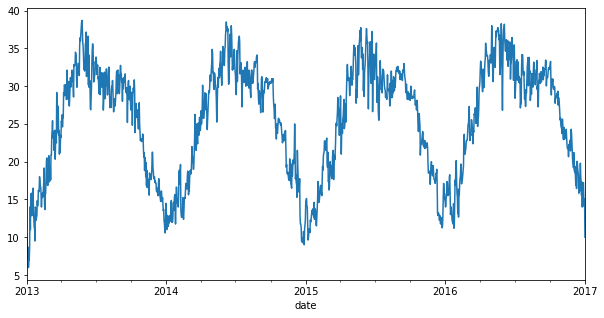

In [6]:
train['meantemp'].plot(figsize=(10,5))

In [7]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

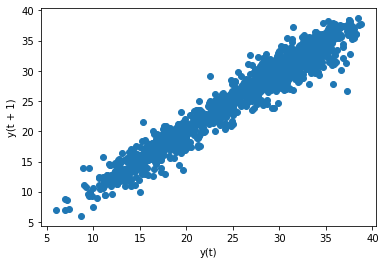

In [8]:
lag_plot(train['meantemp'])

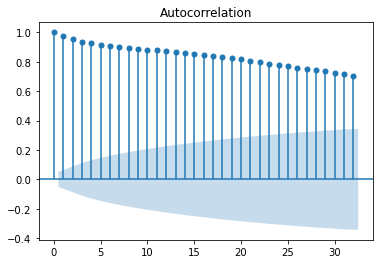

In [9]:
plot_acf(train['meantemp']);
#There is clear indication of the seasonality in the data

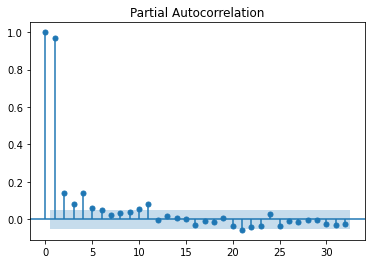

In [10]:
plot_pacf(train['meantemp']);

In [11]:
from statsmodels.tsa.stattools import adfuller

In [13]:
# we will check for the stationarity of the series
# we will make a function so that interpretation of the test will be a little easy

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [14]:
adf_test(train['meantemp'])     

Augmented Dickey-Fuller Test: 
ADF test statistic        -2.021069
p-value                    0.277412
# lags used               10.000000
# observations          1451.000000
critical value (1%)       -3.434865
critical value (5%)       -2.863534
critical value (10%)      -2.567832
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [15]:
from pmdarima import auto_arima

In [16]:
stepwise_fit = auto_arima(train['meantemp'], trace= True, seasonal= True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5546.314, Time=1.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5650.181, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5614.068, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5602.114, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5648.181, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5546.168, Time=0.27 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5573.723, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5544.460, Time=0.52 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5546.100, Time=0.54 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5600.849, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5542.478, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5600.115, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5612.068, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=5544.118, Time=0.38 sec
 ARIMA(1,1,2)(0,0,0)[0]          

In [17]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1462
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2768.239
Date:                Wed, 18 Jan 2023   AIC                           5542.478
Time:                        21:20:58   BIC                           5558.339
Sample:                             0   HQIC                          5548.395
                               - 1462                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5728      0.046     12.494      0.000       0.483       0.663
ma.L1         -0.8028      0.036    -22.070      0.000      -0.874      -0.731
sigma2         2.5896      0.072     36.204      0.000       2.449       2.730
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               255.47
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                            -0.46
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
from statsmodels.tsa.arima.model import ARIMA 

In [21]:
model = ARIMA(train['meantemp'], order = (1,1,1)).fit()

In [22]:
start = len(train)
end = len(train) + len(test) - 1

In [23]:
predictions = model.predict(start, end).rename("ARIMA (1,1,1) Predictions")

<AxesSubplot:xlabel='date'>

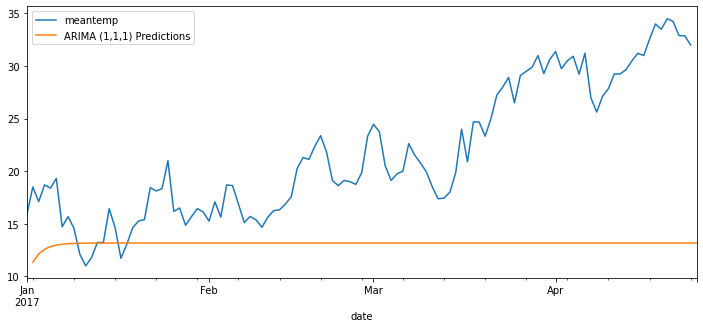

In [27]:
test['meantemp'].plot(figsize=(12,5), legend= True)
predictions.plot(legend = True)

In [28]:
test['meantemp'].mean()

21.71307892022824

In [29]:
predictions.mean()

13.13305374192186